In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import scipy as sp
import scipy.optimize
from typing import List, Tuple

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
PATH = Path("/content/drive/MyDrive/Colab Notebooks/2021-04-BibleText/v0.npy")
STATES = np.load(PATH)
STATES.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(274, 128)

step 0.1990814569113989 25112.0 31354.0
step 0.026441541892322395 24448.0 25112.0
step 0.006871727748691048 24280.0 24448.0
step 0.0028006589785831704 24212.0 24280.0
step 0.0013216586816454656 24180.0 24212.0
step 0.0021505376344086446 24128.0 24180.0
step 0.0013262599469495706 24096.0 24128.0
step 0.0 24096.0 24096.0


{'STATES': -374.0,
 'STATES_CLUSTERED': 9660.0,
 'STATES_FFT': 2898.0,
 'STATES_GREEDY': 10376.0,
 'STATES_GREEDY_V2': 10634.0,
 'STATES_GREEDY_V3': 10170.0,
 'STATES_MEAN': 3718.0,
 'STATES_TWO_OPT': 10976.0}

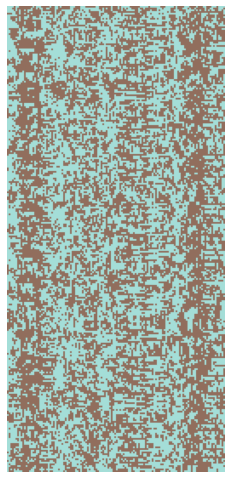

In [ ]:
def mean_state():
    return STATES[:, np.argsort(STATES.mean(0))]

def fft_state():
    idx = np.argsort(
        np.sign(STATES.mean(0)) /
        np.mean(np.abs(sp.fft.fft(STATES - STATES.mean(0, keepdims=True), axis=0)) *
                np.arange(STATES.shape[0])[:, np.newaxis],
                0))
    return STATES[:, idx]

def clustered_state():
    adjacency = 1 - (STATES.T @ STATES) / STATES.shape[0]
    rate = STATES.mean(0)
    rate_order = np.sort(rate.copy())
    def objective(weights: np.ndarray) -> float:
        idx = np.argsort(weights)
        adj_cost = (adjacency[idx[:-1], idx[1:]] ** 2).mean()
        rate_cost = ((rate[idx] - rate_order) ** 2).mean()
        return 3*adj_cost + rate_cost
    initial = np.random.randn(STATES.shape[1])
    bounds = [[0, 1] for _ in range(STATES.shape[1])]
    # result = sp.optimize.minimize(objective, initial, bounds=bounds)
    result = sp.optimize.dual_annealing(objective, bounds, maxfun=int(1e5),
                                        no_local_search=True, seed=102030)
    # result = sp.optimize.differential_evolution(objective, bounds, maxiter=10)
    # result = sp.optimize.basinhopping(objective, initial, niter_success=10000, T=0.1)
    print((objective(initial), result.fun, result.nfev))
    idx = np.argsort(result.x)
    return STATES[:, idx]

def greedy_state():
    seed = np.argmin(STATES.mean(0))
    taken = np.arange(STATES.shape[1]) == seed
    stack = [STATES[:, seed]]
    while not taken.all():
        idx = np.argmax(stack[-1] @ STATES - 1e9 * taken)
        taken[idx] = True
        stack.append(STATES[:, idx])
    return np.stack(stack).T

def greedy_state_v2():
    seed = np.argmax(STATES.var(0))
    taken = np.arange(STATES.shape[1]) == seed
    stack = [STATES[:, seed]]
    while not taken.all():
        at_end = len(stack) % 2 == 0
        idx = np.argmax(stack[-at_end] @ STATES - 1e9 * taken)
        taken[idx] = True
        stack.insert(len(stack) if at_end else 0, STATES[:, idx])
    return np.stack(stack).T

def greedy_state_v3():
    states = STATES.T
    lhs, rhs = np.argmin(states.mean(1)), np.argmax(states.mean(1))
    stack = states[[lhs, rhs]]
    for idx in np.argsort(np.abs(states.mean(1))):
        if idx not in [lhs, rhs]:
            scores = stack @ states[idx]
            current_scores = np.sum(stack[:-1] * stack[1:], 1)
            target = 1 + np.argmax(scores[1:] + scores[:-1] - current_scores)
            stack = np.concatenate([stack[:target], states[np.newaxis, idx], stack[target:]], 0)
    assert STATES.shape == stack.T.shape
    return stack.T

def two_opt_state(state):
    # https://stackoverflow.com/questions/25585401/travelling-salesman-in-scipy

    # Calculate the euclidian distance in n-space of the route r traversing cities c, ending at the path start.
    #path_distance = lambda r,c: np.sum([np.linalg.norm(c[r[p]]-c[r[p-1]]) for p in range(len(r))])
    path_distance = lambda r,c: c.size - ordering_score(c[r].T)
    # Reverse the order of all elements from element i to element k in array r.
    two_opt_swap = lambda r,i,k: np.concatenate((r[0:i],r[k:-len(r)+i-1:-1],r[k+1:len(r)]))

    def two_opt(cities,improvement_threshold): # 2-opt Algorithm adapted from https://en.wikipedia.org/wiki/2-opt
        route = np.arange(cities.shape[0]) # Make an array of row numbers corresponding to cities.
        improvement_factor = 1 # Initialize the improvement factor.
        best_distance = path_distance(route,cities) # Calculate the distance of the initial path.
        while improvement_factor > improvement_threshold: # If the route is still improving, keep going!
            distance_to_beat = best_distance # Record the distance at the beginning of the loop.
            for swap_first in range(1,len(route)-2): # From each city except the first and last,
                for swap_last in range(swap_first+1,len(route)): # to each of the cities following,
                    new_route = two_opt_swap(route,swap_first,swap_last) # try reversing the order of these cities
                    new_distance = path_distance(new_route,cities) # and check the total distance with this modification.
                    if new_distance < best_distance: # If the path distance is an improvement,
                        route = new_route # make this the accepted best route
                        best_distance = new_distance # and update the distance corresponding to this route.
            improvement_factor = 1 - best_distance/distance_to_beat # Calculate how much the route has improved.
            print(f"step {improvement_factor} {best_distance} {distance_to_beat}")
        return route # When the route is no longer improving substantially, stop searching and return the route.

    return state[:, two_opt(state.T, 1e-6)]


def ordering_score(state: np.ndarray) -> float:
    return np.sum(state[:, :-1] * state[:, 1:])

# STATES_MEAN = mean_state()
# STATES_FFT = fft_state()
# STATES_CLUSTERED = clustered_state()
# STATES_GREEDY = greedy_state()
# STATES_GREEDY_V2 = greedy_state_v2()
# STATES_GREEDY_V3 = greedy_state_v3()
STATES_TWO_OPT = two_opt_state(mean_state())
display({name: ordering_score(globals()[name]) for name in [
    "STATES", "STATES_MEAN", "STATES_FFT", "STATES_CLUSTERED",
    "STATES_GREEDY", "STATES_GREEDY_V2", "STATES_GREEDY_V3",
    "STATES_TWO_OPT",
]})
plt.figure(figsize=(4, 4 * STATES.shape[0] / STATES.shape[1]))
show(STATES_TWO_OPT, "#A4DED8 #916E5D", plt.gca())

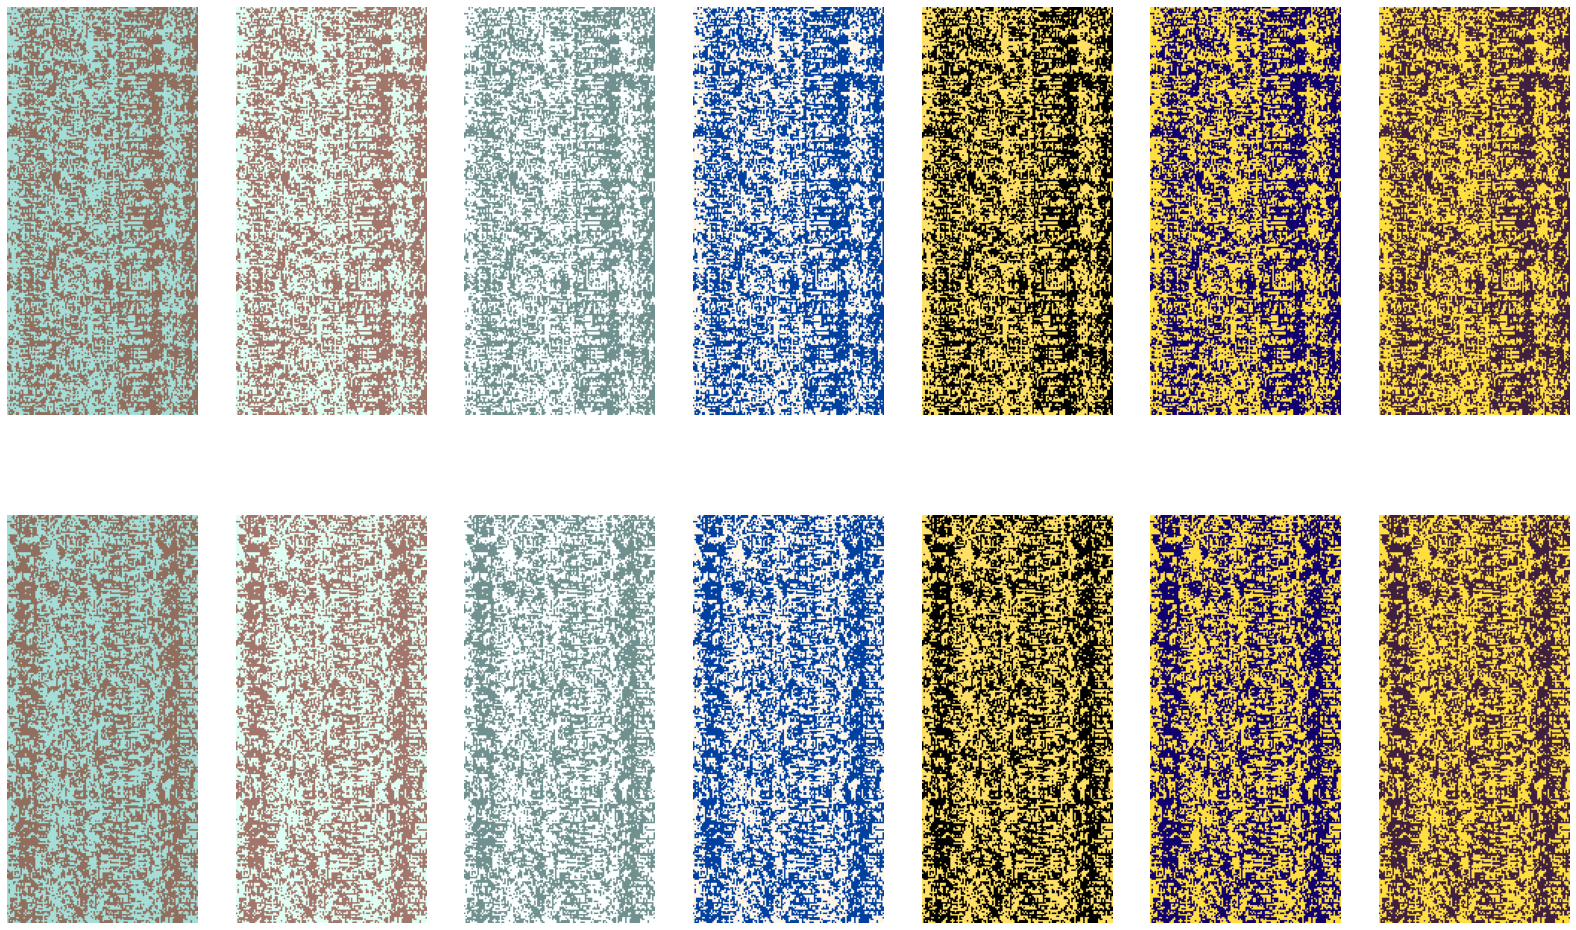

In [ ]:
def colorize(x: np.ndarray, c: str) -> np.ndarray:
    return np.where(np.signbit(x)[..., np.newaxis], *map(matplotlib.colors.to_rgb, c.split(" ")))

def show(x: np.ndarray, c: str, ax: plt.Axes) -> None:
    ax.imshow(colorize(x, c))
    ax.axis("off")

def show_grid(items: List[List[Tuple[np.ndarray, str]]], width: float) -> None:
    height = width * STATES.shape[0] / STATES.shape[1]
    nrows = len(items)
    ncols = len(items[0])
    _, axs = plt.subplots(nrows, ncols, figsize=(ncols * width, nrows * height))
    for row, row_ax in zip(items, axs):
        for (x, c), ax in zip(row, row_ax):
            show(x, c, ax)

show_grid([
    [
        (state, color)
        for color in ["#A4DED8 #916E5D", "#E0FFF4 #A3766C", "#FCFFFF #70918F", "#FEF7E9 #0040A1", "#FFE066 #000000", "#FFDF40 #100070", "#FFDF40 #402040"]
    ]
    for state in [STATES_GREEDY_V3, STATES_TWO_OPT]
], width=4)

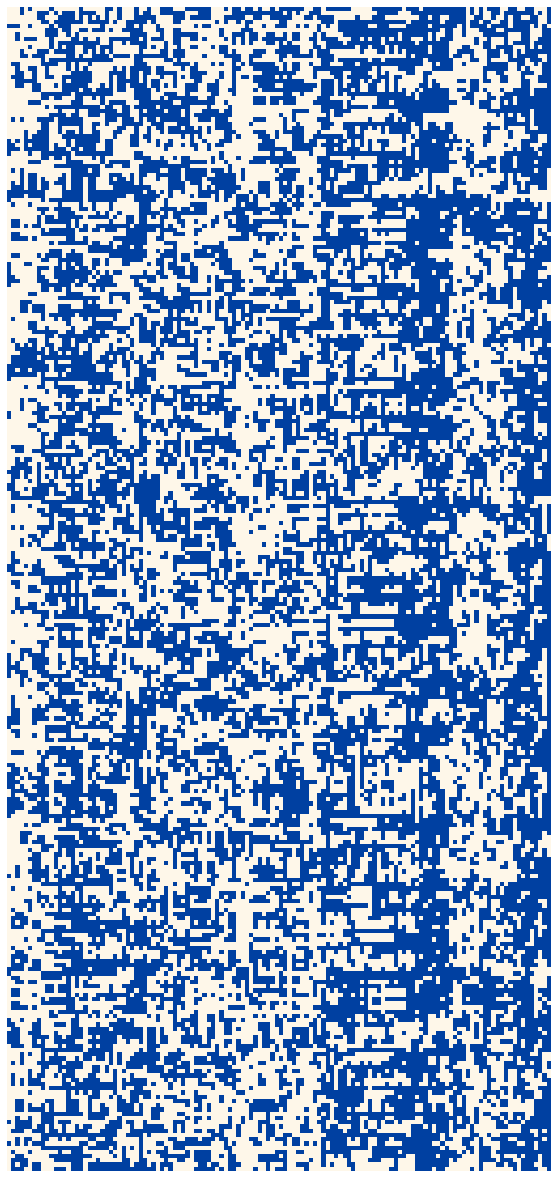

In [ ]:
plt.figure(figsize=(10, 10 * STATES.shape[0] / STATES.shape[1]))
show(STATES_GREEDY_V3, "#FEF7E9 #0040A1", plt.gca())